# Amazon Review Example

<hr/>

## import statements

Let's start with a few important import statements. Notice there are some conventions here in naming the packages. Often you will run across code using this conventions so I thought I would use them here. 

Additionally we are using a feature that plots all our output into this notebook. This is a preference and by no means necessary, but we like to have everything inline. By using the `%matplotlib inline` that the top of the next cell all our plots based on the matplotlib package will be inline. By using `output_notebook` from bokeh we have the same effect for its plots.

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import bokeh
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

Here's the versions of the libraries I'm using. You might see if they match your own.

In [2]:
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("MatPlotLib version: {}".format(mpl.__version__))
print("Seaborn version: {}".format(sns.__version__))
print("Scikit-Learn version: {}".format(sklearn.__version__))
print("Bokeh version: {}".format(bokeh.__version__))

Numpy version: 1.11.0
Pandas version: 0.18.1
MatPlotLib version: 1.5.1
Seaborn version: 0.7.0
Scikit-Learn version: 0.17.1
Bokeh version: 0.11.1


In [3]:
sns.set(color_codes=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "figure.figsize": (20, 12)})
label_size = 24
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size 

<hr/>

## Loading some data

We have some data from an [Amazon Product](http://jmcauley.ucsd.edu/data/amazon/) scrape by [Julian McAuley](http://cseweb.ucsd.edu/~jmcauley/). If you use this data please cite Julian!

Let's see what we have, note we can use some bash commands in Jupyter by starting a line with `!`

In [4]:
! ls -al data

total 0
drwxr-xr-x   4 aterrel  staff  136 May 23 09:58 .
drwxr-xr-x  13 aterrel  staff  442 May 25 14:41 ..
drwxr-xr-x   4 aterrel  staff  136 May 23 09:58 boston
drwxr-xr-x   3 aterrel  staff  102 May 23 09:58 reviews


But in reality you don't have to us it for some commands like `ls` and `cd`

In [5]:
ls -alh data/reviews/

total 92360
drwxr-xr-x  3 aterrel  staff   102B May 23 09:58 ./
drwxr-xr-x  4 aterrel  staff   136B May 23 09:58 ../
-rw-r--r--  1 aterrel  staff    45M May 23 09:58 reviews_Clothing_Shoes_and_Jewelry_5.json.gz


The complete data is pretty large, but the individual departments are not so bad. But let's try to get a feel for how to build this data:

In [6]:
!gzcat ../data/reviews/reviews_Clothing_Shoes_and_Jewelry_5.json.gz | head -2

{"reviewerID": "A1KLRMWW2FWPL4", "asin": "0000031887", "reviewerName": "Amazon Customer \"cameramom\"", "helpful": [0, 0], "reviewText": "This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++", "overall": 5.0, "summary": "Great tutu-  not cheaply made", "unixReviewTime": 1297468800, "reviewTime": "02 12, 2011"}
{"reviewerID": "A2G5TCU2WDFZ65", "asin": "0000031887", "reviewerName": "Amazon Customer", "helpful": [0, 0], "reviewText": "I bought this for my 4 yr old daughter for dance class, she wore it today for the first time and the teacher thought it was adorable. I bought this to go with a light blue long sleeve leotard and was happy the colors matched up great. Price was very good too since some of these go for over $15.00 dollars.", "overall": 5.0, "summary": "Very Cute!!", "unixReviewTime": 1358553600, "reviewTime": "01 19, 2013"}
gzcat: error writing to output: Br

Oph! This is JSON Lines not JSON! Let's load it into lines

In [7]:
import gzip
review_lines = gzip.open('../data/reviews/reviews_Clothing_Shoes_and_Jewelry_5.json.gz', 'rt').readlines()
len(review_lines)

278677

Now we have something, but it's a lot of lines. So we load it into a `DataFrame`, an object that is the data hacker's go to for manipulating structured data. 

Unfortunately, its not as straight forward as `pd.read_json`, since first we have to turn all those JSON strings into Python objects, so let's turn each into a dict and then build a `DataFrame`

In [8]:
import json
df_reviews = pd.DataFrame(list(map(json.loads, review_lines)))

Now let's see what we have:

In [9]:
df_reviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5.0,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5.0,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5.0,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5.0,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5.0,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


Okay the overall votes is a number, let's make some statistics about them. First we extract the series object out of the data frame.

In [10]:
overall = df_reviews['overall']

In [11]:
overall.describe()

count    278677.000000
mean          4.245133
std           1.103747
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

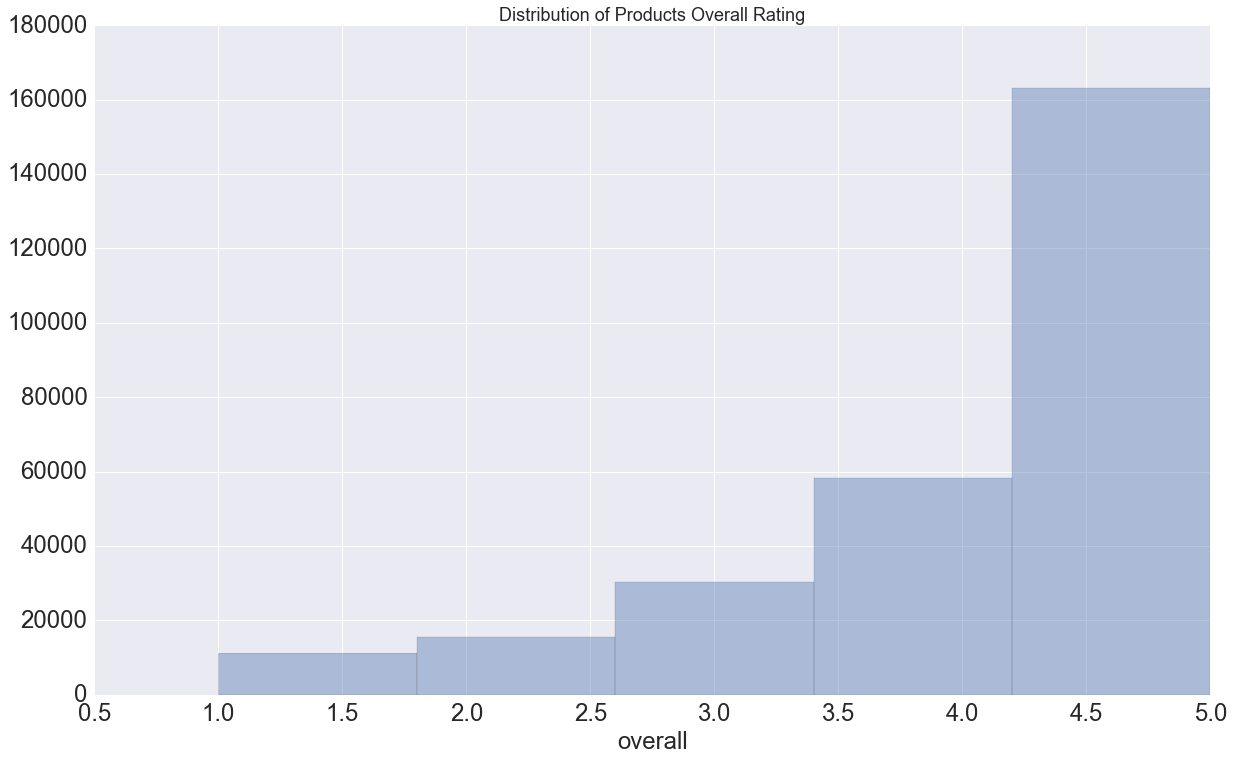

In [12]:
plt.figure()
g = sns.distplot(overall, kde=False, bins=5) 
g.set_title("Distribution of Products Overall Rating")

Let's actually use those helpful votes as well.

In [13]:
df_reviews['helpful_votes'] = df_reviews['helpful'].apply(lambda row: row[0])
df_reviews['overall_votes'] = df_reviews['helpful'].apply(lambda row: row[1])
df_reviews['percent_helpful'] = df_reviews['helpful_votes'] / df_reviews['overall_votes']
df_reviews['review_helpful'] = np.where((df_reviews.percent_helpful > .7) & (df_reviews.helpful_votes > 5), "Yes", "No")

In [14]:
df_reviews.describe()

/Users/aterrel/miniconda/envs/pydata101/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall,unixReviewTime,helpful_votes,overall_votes,percent_helpful
count,278677.000000,2.786770e+05,278677.000000,278677.00000,87021.000000
mean,4.245133,1.374197e+09,1.145936,1.34460,0.780014
std,1.103747,2.904510e+07,6.579834,7.05004,0.346846
min,1.000000,1.048896e+09,0.000000,0.00000,0.000000
25%,4.000000,1.362787e+09,0.000000,0.00000,NaN
50%,5.000000,1.382141e+09,0.000000,0.00000,NaN
75%,5.000000,1.393200e+09,1.000000,1.00000,NaN
max,5.000000,1.406074e+09,1200.000000,1267.00000,2.000000


In [15]:
df_reviews['percent_helpful'].dropna().describe()

count    87021.000000
mean         0.780014
std          0.346846
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          2.000000
Name: percent_helpful, dtype: float64

In [16]:
ph = df_reviews['percent_helpful']

In [17]:
ph[ph > 1.0]

30730    2.0
Name: percent_helpful, dtype: float64

In [18]:
df_reviews.loc[30730]

asin                                                      B000JD2614
helpful                                                       [4, 2]
overall                                                            5
reviewText         I have been waiting for these to go on sale fo...
reviewTime                                               02 17, 2009
reviewerID                                            A353U0L2HAMSHV
reviewerName                    Cricket "Living life and loving it!"
summary                                               A gift for me!
unixReviewTime                                            1234828800
helpful_votes                                                      4
overall_votes                                                      2
percent_helpful                                                    2
review_helpful                                                    No
Name: 30730, dtype: object

In [19]:
ph = ph[ph < 1.1]

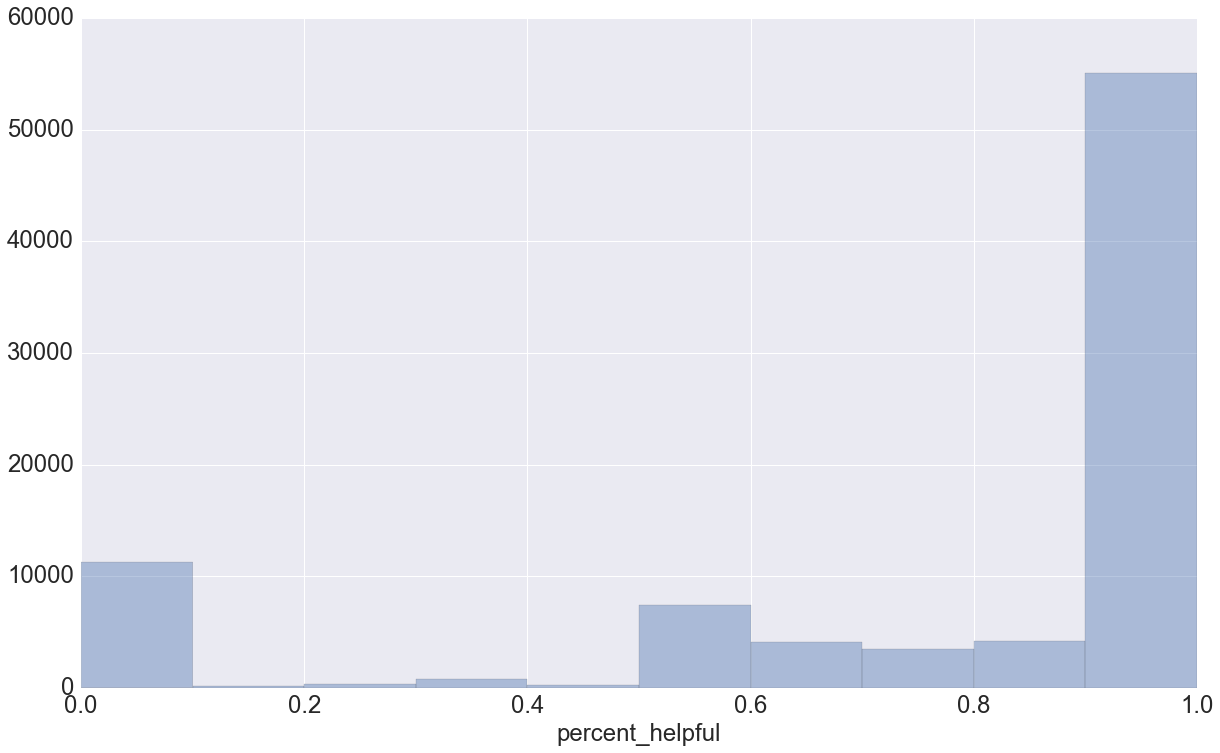

In [20]:
sns.distplot(ph, kde=False, bins=10)

<hr/>

# Modelling with the text

Let's first split our data into a training set and test set, below we use a 80/20 split.

In [21]:
from sklearn.cross_validation import train_test_split
df_train, df_test = train_test_split(df_reviews, test_size=0.2, random_state=0)

Ok, now that we have our data split into training and test, let's create our word matrix!  We do with the CountVectorizer function

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(df_train.reviewText)

What this just did is used our training data and created the word matrix.  Now the next step is to apply this matrix to our test data set.  If the word wasn't seen in the training data set, then it won't be in our word matrix we create for our test data set

In [23]:
X_test = count_vectorizer.transform(df_test.reviewText)

In [24]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, df_train.review_helpful)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
lg_score = lg.score(X_test, df_test.review_helpful)
"Logistic Regression mean accuracy: " + str(lg_score)

'Logistic Regression mean accuracy: 0.956042773073'

Precision: What percentage of our predicted helpful reviews are actually helpful reviews? Aka, when our model says that a review is helpful, what percentage of the time is it actually hepful?

Recall: What percentage of helpful reviews did we actually catch with our model? Example, if there were 1,000 helpful reviews, how many of them did we correctly identify as helpful?

In [26]:
lg_pred = lg.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test.review_helpful, lg_pred)

array([[53086,   431],
       [ 2019,   200]])

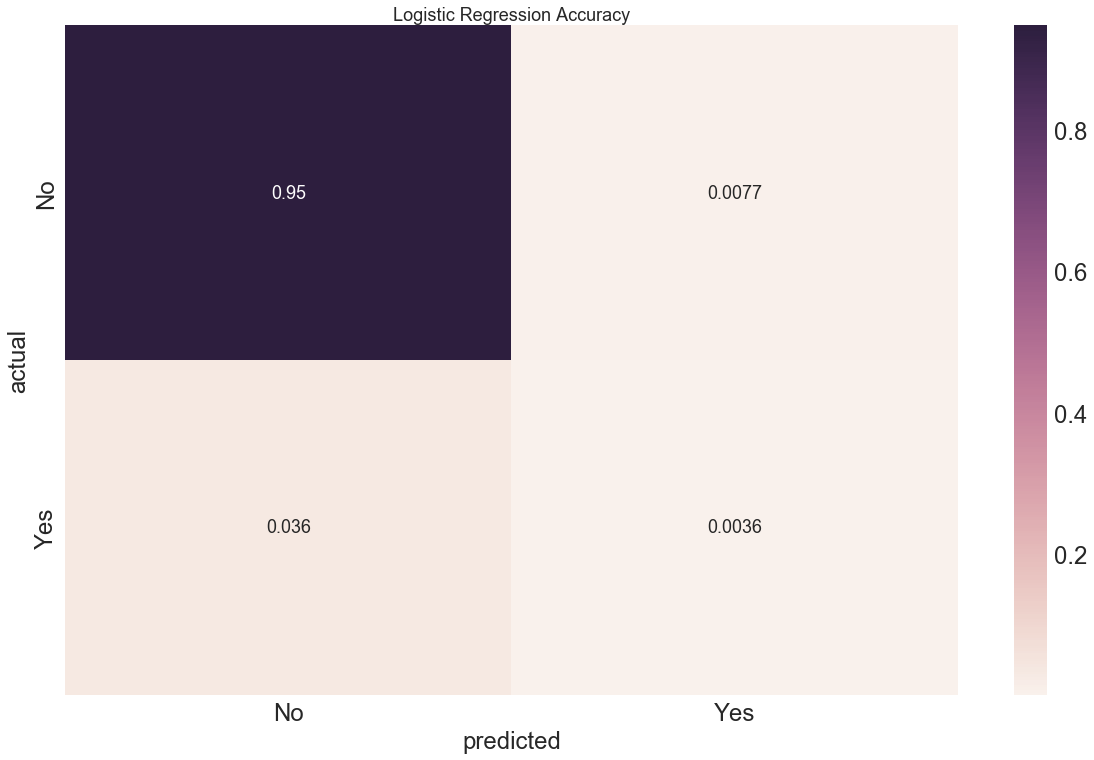

In [28]:
df = pd.DataFrame(confusion_matrix(df_test.review_helpful, lg_pred),
                  columns=['No', 'Yes'], index=['No', 'Yes'])
sns.heatmap(df / len(lg_pred), annot=True)
plt.title("Logistic Regression Accuracy")
plt.ylabel('actual')
plt.xlabel('predicted')

In [29]:
sorted_coef_indexes = np.argsort(lg.coef_[0])
feature_names = count_vectorizer.get_feature_names()
ten_highest = [feature_names[idx] for idx in sorted_coef_indexes[-10:]]
print(ten_highest)
ten_lowest = [feature_names[idx] for idx in sorted_coef_indexes[:10]]
print(ten_lowest)

['ashamed', 'urging', 'estimation', 'bandaids', 'coolness', 'konedog', 'definition', 'elevated', 'facets', '117lbs']
['bearpaw', 'expressed', 'til', 'wink', 'firmer', 'toms', 'halter', 'requested', 'accepted', 'lumpy']


How about using Term Frequencies?

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)
X_train_tf.shape

X_test_tf = tf_transformer.transform(X_test)

In [31]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_train_tfidf.shape

X_test_tfid = tfidf_transformer.transform(X_test)

In [32]:
from sklearn.naive_bayes import MultinomialNB
clf_tf = MultinomialNB().fit(X_train_tf, df_train.review_helpful)
clf_tf.score(X_test, df_test.review_helpful)

0.95979259365580594

In [33]:
clf_tfid = MultinomialNB().fit(X_train_tfidf, df_train.review_helpful)
clf_tfid.score(X_test, df_test.review_helpful)

0.95988230228218741

In [34]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [35]:
text_clf = text_clf.fit(df_train.reviewText, df_train.review_helpful)

In [36]:
predicted = text_clf.predict(df_test.reviewText)

In [37]:
text_clf.predict(["The diamond was a very nice cut. The gold could have been a bit more pure."])

array(['No'], 
      dtype='<U3')

In [38]:
text_clf.predict([" ".join(ten_lowest)])

array(['No'], 
      dtype='<U3')

In [39]:
text_clf.predict([" ".join(ten_highest)])

array(['Yes'], 
      dtype='<U3')

In [40]:
from sklearn import metrics
print(metrics.classification_report(df_test.review_helpful, predicted))

             precision    recall  f1-score   support

         No       0.96      1.00      0.98     53517
        Yes       0.00      0.00      0.00      2219

avg / total       0.92      0.96      0.94     55736

